In [47]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

#### Prepare for Dataset

In [48]:
file  = open('SeriesOfUnforunateEvents-Book9-Chapter1.txt').read()
unique_chars = {}
idx = 0
for char in file:
    if char not in unique_chars:
        unique_chars[char] = idx
        idx += 1
n_chars = len(unique_chars.keys())
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(unique_chars.keys()))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 245191
All possible characters: dict_keys(['W', 'h', 'e', 'n', ' ', 'm', 'y', 'w', 'o', 'r', 'k', 'd', 'a', 'i', 's', 'v', ',', 'I', 'c', 'l', 't', 'b', 'p', '\n', 'f', 'u', 'g', '.', 'S', 'A', 'z', 'B', 'F', '“', '”', 'x', '’', 'T', '-', 'U', 'j', 'q', 'C', 'O', 'E', 'V', 'K', 'L', 'M', 'N', '?', 'Y', 'D', 'P', '!', 'R', 'G', 'H', '‘', 'Q', '5', 'J', '9', "'", '6', '7', ':', '—', 'X', '¬'])
Number of all possible characters: 70


In [49]:
decoded_chars = {}
for key in unique_chars.keys():
    val = unique_chars[key]
    decoded_chars[val] = key

In [50]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = unique_chars[char]
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = unique_chars[char]
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [51]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


#### Network Definition

In [52]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        self.hidden_layer = nn.RNNCell(self.input_size,self.hidden_size) 
        self.output_layer = nn.Linear(self.hidden_size,self.output_size)
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        hidden = self.hidden_layer(input,hidden)
        output = self.output_layer(hidden)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (hidden_layer): RNNCell(70, 100)
  (output_layer): Linear(in_features=100, out_features=70, bias=True)
)

#### Training Step and Evaluation Step

In [53]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [54]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = decoded_chars[predicted_index.item()]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [55]:
# Number of iterations.
iters       = 20000  # Number of training iterations.
print_iters = 200    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:199/20000 loss:2.7960476875305176
generated sequence: Ws oud 
buof, wh. VMod tsternl-yandcep mhainglind lo of en illck ond nme rondtonter iny nntr rarerg, 

iter:399/20000 loss:2.285923719406128
generated sequence: We,” Qivtigudded ald turr asa tered ga cuut. Hed  fiot sed th ths wailw th owevin ousa tas aud linge 

iter:599/20000 loss:2.1438679695129395
generated sequence: We t! 

I momede the-finiven savernds tho kanded” Klaus-y’ir a med beuglad ther shay and mathde madsh

iter:799/20000 loss:2.050018548965454
generated sequence: We 
luired, thut thereyts bettersitelaallyything, wing care calf coullons asamwers felais. 

“Olef th

iter:999/20000 loss:2.00087833404541
generated sequence: We he canry sato you yon that ea, would Vhide sous,” Vyole.” 

“Anbut bectunn be Ile seint, hand, Ild

iter:1199/20000 loss:1.9208053350448608
generated sequence: We 
rowale sithe, at can wile 
therenfugheve 
wint it wige. “The pis!” Suent ous and you counslick ht

iter:1399/20000 loss:1.92883348

#### Training Loss Curve

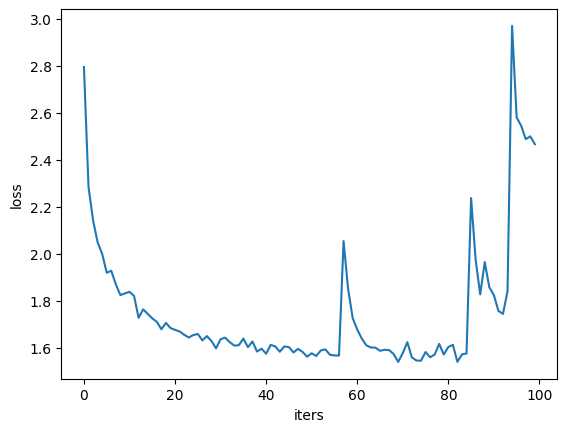

In [56]:
plt.xlabel('iters')
plt.ylabel('loss')
all_losses = [loss.item() for loss in all_losses]
plt.plot(np.array(all_losses))
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [57]:
print(eval_step(net, predicted_len=600))

Waisob sath sauly, se  M in wit moueexwad ly ase thinssaring. ni? y “ayid toan ilmine!”d!t cald the uu“Co ss?” as? aalt as  wand them nhet s insmming Iamrk.ing bfrukchanfu temavly fous thime,”hr. whigy treitabeo Very. 
Nad ivoad hask licabaicth no thay. thet mun y rong sallic apths lo ar.” .hdny, s.ulet,”atd to sme f thand dat ly, ield foblom oun housyopst lamcoryed thkishit sof HBthath witondacl wisninled Ol mouthing.st thivenc whdlh waulextest dy the linty mhfeed. old. 
“es st nsf sory uttelare tirni lavs sf snvarny inh. 
ston. lht vit no”h thas. wo “din lainc Bny thon sle tistednots tund mac


### Method

This is the original method employed in class but trained on different text.